In [1]:
# import libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
# wikipedia web page of all grand slam singles finals
web_page = 'https://en.wikipedia.org/wiki/List_of_Grand_Slam_singles_finals'
# read in mens data into winners dataframe. currently table 1 - may need updating when page changes
df = pd.read_html(web_page)[1]
# set first row as column names
df = df.rename(columns=df.iloc[0]).drop(df.index[0])

In [3]:
# Function to return (approx) tournament date from year
def get_date(tournament,year):
    if 'Australian' in tournament or 'Australasian' in tournament:
        date = pd.to_datetime({'year':[year[:4]], 'month': [1], 'day': [30]})
    elif 'French' in tournament:
        date = pd.to_datetime({'year':[year[:4]], 'month': [5], 'day': [30]})    
    elif 'Wimbledon' in tournament:
        date = pd.to_datetime({'year':[year[:4]], 'month': [6], 'day': [30]})
    elif 'US' in tournament or 'U.S.' in tournament:
        date = pd.to_datetime({'year':[year[:4]], 'month': [8], 'day': [30]})    
    return date

# Get tournament dates
df['Date'] = df.apply(lambda row: get_date(row['Tournament'],row['Year']),axis=1) # This is in Timestamp format

# Sort dataframe by date
df = df.sort_values('Date')

In [4]:
# Create Wins column - group by winner name and add up. Remember to add 1 to start sum at 1
df['Wins'] = df.groupby('Winner').cumcount()+1

# Take a look at the top 10
df.groupby('Winner').nunique()['Wins'].sort_values(ascending=False).head(10)

Winner
Roger Federer        20
Rafael Nadal         19
Novak Djokovic       17
Pete Sampras         14
Roy Emerson          12
Rod Laver            11
Björn Borg           11
William T. Tilden    10
Fred Perry            8
Andre Agassi          8
Name: Wins, dtype: int64

In [5]:
# Take only dates after 2000
df = df[df['Date']>= datetime.datetime(2000, 1, 1)]

In [6]:
# Create dataframe of all dates between 1st Jan 2000 and now with day frequency
rng = pd.date_range(start = df['Date'].iloc[0], end = datetime.datetime.now().date(), freq='d')
df_dates = pd.DataFrame({ 'Date': rng}) # this is in datetime64 format

# convert to datetime.date format
df_dates = pd.to_datetime(df_dates['Date']).dt.date

In [7]:
# Convert the date in winners dataframe to datetime.date format
df['Date'] = df['Date'].apply(lambda x: x.date())

In [8]:
# Join the dates dataframe and the winners dataframe together, based on index. We now have a dataframe of dates 
# from 1st Jan 2000 until now with entries where a Grand Slam took place
df = df_dates.to_frame().set_index('Date').join(df.set_index('Date'), rsuffix='_other')

In [9]:
# Reset index and create Date column again
df.reset_index(inplace=True)

In [10]:
# Change NaN to blank in Winner and Tournament columns so following manipulation works
df['Winner'] = df['Winner'].fillna('')
df['Tournament'] = df['Tournament'].fillna('')

In [11]:
# Create player columns with number of wins, forward filled to fill in nan entries
df['Federer'] = df.apply(lambda row: row['Wins'] if 'Federer' in row['Winner'] else np.nan, axis=1).fillna(method='ffill')
df['Nadal'] = df.apply(lambda row: row['Wins'] if 'Nadal' in row['Winner'] else np.nan, axis=1).fillna(method='ffill')
df['Djokovic'] = df.apply(lambda row: row['Wins'] if 'Djokovic' in row['Winner'] else np.nan, axis=1).fillna(method='ffill')

In [12]:
# Add in a zero on the date before 1st win so that graphs start at zero
df['Federer'].loc[df.index[df['Federer']==1][0]-1] = 0
df['Nadal'].loc[df.index[df['Nadal']==1][0]-1] = 0
df['Djokovic'].loc[df.index[df['Djokovic']==1][0]-1] = 0

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


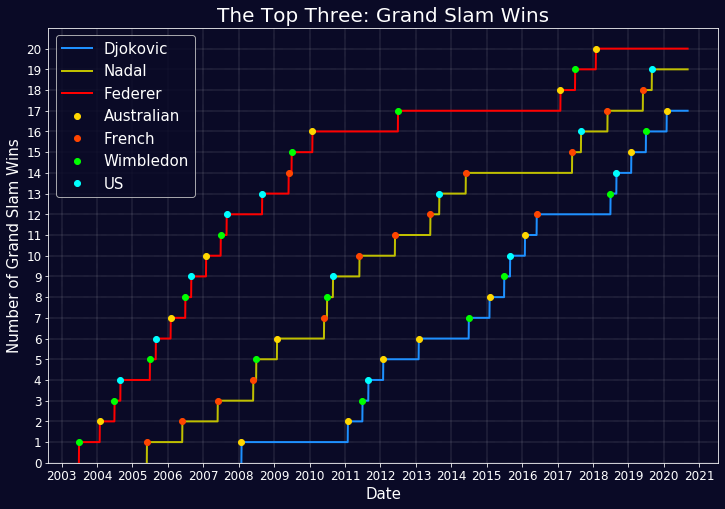

In [13]:
# Plot Grand Slam wins against tournament date
plt.rcParams['figure.facecolor']=(10/255, 10/255, 38/255) 
plt.rcParams['axes.facecolor']=(10/255, 10/255, 38/255)
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['text.color'] = 'white'
plt.rcParams['grid.color'] = 'white'
plt.rcParams['axes.edgecolor']='white'

fig,ax = plt.subplots(figsize=(12,8))

ax.plot(df['Date'],df['Djokovic'],'dodgerblue',linewidth=2)
ax.plot(df['Date'],df['Nadal'],'y',linewidth=2)
ax.plot(df['Date'],df['Federer'],'r',linewidth=2)

tournament_colors = ['gold','orangered','lime','aqua']
# Plot one of Australian, French, Wimbledon and US so legend is correct
for name in ['Federer','Nadal','Djokovic']:
    for i, tournament in enumerate(['Australian','French','Wimbledon','US']):
        row = df[df['Winner'].str.contains(name) & (df['Tournament'].str.contains(tournament))]
        ax.plot(row['Date'],row[name],'o',markerfacecolor=tournament_colors[i],markeredgecolor=tournament_colors[i])

year = range(2003,2022)
xtickvals = (np.array(year, dtype='datetime64[Y]')-1970).astype('datetime64[s]').tolist()
            
plt.yticks(range(0,21))
plt.xticks(xtickvals)
plt.ylim([0,21])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(color='w', linestyle='--', linewidth=0.2)

plt.xlabel('Date', fontsize=15 , color='white')
plt.ylabel('Number of Grand Slam Wins', fontsize=15 , color='white')
plt.tick_params(labelsize=12)
plt.title(label='The Top Three: Grand Slam Wins',fontsize=20)
plt.legend(['Djokovic','Nadal','Federer','Australian','French','Wimbledon','US'],fontsize=15)

plt.savefig('the_top_three.png',bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')

In [14]:
# Calculate number of years since first grand slam win for each dataframe entry
df['FedererDifference'] = df['Date'].apply(lambda x: (x -df[df['Federer']==1].iloc[0]['Date']).days/365.2425)
df['NadalDifference'] = df['Date'].apply(lambda x: (x -df[df['Nadal']==1].iloc[0]['Date']).days/365.2425)
df['DjokovicDifference'] = df['Date'].apply(lambda x: (x -df[df['Djokovic']==1].iloc[0]['Date']).days/365.2425)

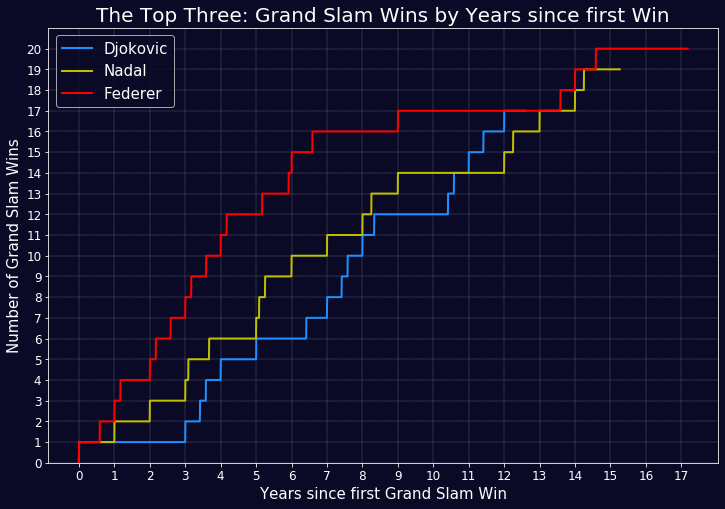

In [15]:
# Plot Grand Slam wins against years since first win

plt.rcParams['figure.facecolor']=(10/255, 10/255, 38/255) 
plt.rcParams['axes.facecolor']=(10/255, 10/255, 38/255)
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['text.color'] = 'white'
plt.rcParams['grid.color'] = 'white'
plt.rcParams['axes.edgecolor']='white'

fig,ax = plt.subplots(figsize=(12,8))

ax.plot(df['DjokovicDifference'],df['Djokovic'],'dodgerblue',linewidth=2)
ax.plot(df['NadalDifference'],df['Nadal'],'y',linewidth=2)
ax.plot(df['FedererDifference'],df['Federer'],'r',linewidth=2)

xtickvals = range(0,18)
            
plt.yticks(range(0,21))
plt.xticks(xtickvals)
plt.ylim([0,21])
ax.grid(color='w', linestyle='--', linewidth=0.2)

plt.xlabel('Years since first Grand Slam Win', fontsize=15 , color='white')
plt.ylabel('Number of Grand Slam Wins', fontsize=15 , color='white')
plt.tick_params(labelsize=12)
plt.title(label='The Top Three: Grand Slam Wins by Years since first Win',fontsize=20)
plt.legend(['Djokovic','Nadal','Federer'],fontsize=15)

plt.savefig('the_top_three_by_years.png',bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')

In [16]:
# Define when players were born and calculate age at each dataframe entry
fed_born = datetime.datetime(1981, 8, 8).date()
nad_born = datetime.datetime(1986, 6, 3).date()
djo_born = datetime.datetime(1987, 5, 22).date()

df['FedererAge'] = df['Date'].apply(lambda x: (x - fed_born).days/365.2425)
df['NadalAge'] = df['Date'].apply(lambda x: (x - nad_born).days/365.2425)
df['DjokovicAge'] = df['Date'].apply(lambda x: (x - djo_born).days/365.2425)

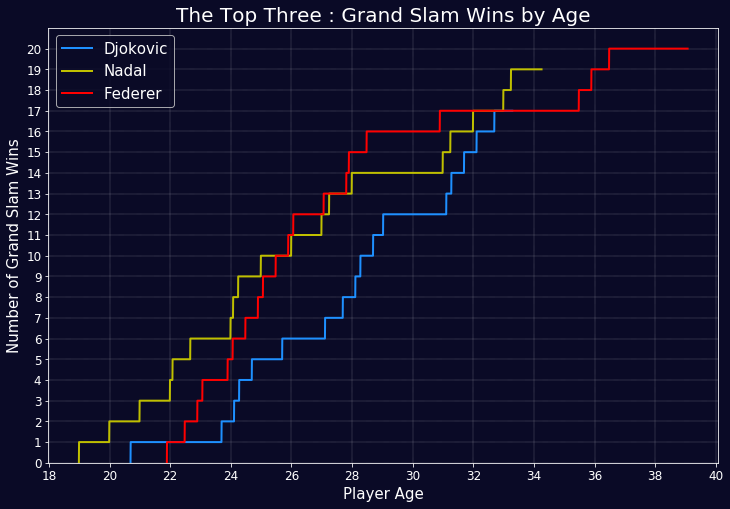

In [17]:
# Plot Grand Slam wins against player age

plt.rcParams['figure.facecolor']=(10/255, 10/255, 38/255) 
plt.rcParams['axes.facecolor']=(10/255, 10/255, 38/255)
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['text.color'] = 'white'
plt.rcParams['grid.color'] = 'white'
plt.rcParams['axes.edgecolor']='white'

fig,ax = plt.subplots(figsize=(12,8))

ax.plot(df['DjokovicAge'],df['Djokovic'],'dodgerblue',linewidth=2)
ax.plot(df['NadalAge'],df['Nadal'],'y',linewidth=2)
ax.plot(df['FedererAge'],df['Federer'],'r',linewidth=2)

xtickvals = range(18,41,2)
            
plt.yticks(range(0,21))
plt.xticks(xtickvals)
plt.ylim([0,21])
ax.grid(color='w', linestyle='--', linewidth=0.2)

plt.xlabel('Player Age', fontsize=15 , color='white')
plt.ylabel('Number of Grand Slam Wins', fontsize=15 , color='white')
plt.tick_params(labelsize=12)
plt.title(label='The Top Three : Grand Slam Wins by Age',fontsize=20)
plt.legend(['Djokovic','Nadal','Federer'],fontsize=15)

plt.savefig('the_top_three_by_age.png',bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')